# Fitting a logistic model to German credit data

This notebook explains how to run the toy logistic regression model example using the German credit data from [1]. In this example, we have predictors for 1000 individuals and an outcome variable indicating whether or not each individual should be given credit.


[1] "UCI machine learning repository", 2010. A. Frank and A. Asuncion. https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)

In [1]:
import pints
import pints.toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt
import io
import urllib
from scipy import stats
import time

To run this example, we need to first get the data from [1] and process it so we have dichtonomous $y\in\{-1,1\}$ outputs and the matrix of predictors has been standardised. In addition, we also add a column of 1s corresponding to a constant term in the regression.

If you are connected to the internet, by instantiating with `x=None`, Pints will fetch the data from the repo for you. If, instead, you have local copies of the `x` and `y` matrices, these can be supplied as arguments. 

In [2]:
logpdf = pints.toy.GermanCreditLogPDF()

Let's look at the data: `x` is a matrix of predictors and `y` is a vector of credit recommendations for 1000 individuals. 

Specifically, let's look at the PCA scores and plot the first two dimensions against one another. Here, we see that the two groups overlap substantially, but that there neverless some separation along the first PCA component.

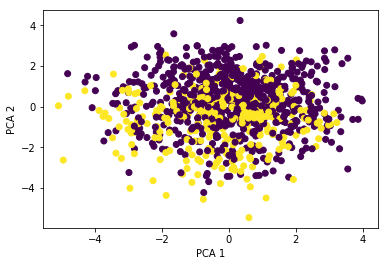

In [3]:
def pca(X):
  # Data matrix X, assumes 0-centered
  n, m = X.shape
  # Compute covariance matrix
  C = np.dot(X.T, X) / (n-1)
  # Eigen decomposition
  eigen_vals, eigen_vecs = np.linalg.eig(C)
  # Project X onto PC space
  X_pca = np.dot(X, eigen_vecs)
  return X_pca

x, y = logpdf.data()
scores = pca(x)

# colour individual points by whether or not to recommend them credit
plt.scatter(scores[:, 0], scores[:, 1], c=y)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

Now we run HMC to fit the parameters of the model.

In [4]:
xs = [
    np.random.uniform(0, 1, size=(logpdf.n_parameters())),
    np.random.uniform(0, 1, size=(logpdf.n_parameters())),
    np.random.uniform(0, 1, size=(logpdf.n_parameters())),
]

mcmc = pints.MCMCController(logpdf, len(xs), xs, method=pints.HamiltonianMCMC)
mcmc.set_max_iterations(200)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(10)

for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size(0.2)
    sampler.set_leapfrog_steps(10)

start = time.time()    

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

end = time.time()  
diff = end - start

Running...
Using Hamiltonian Monte Carlo
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.1
1     33     0.333     0.333     0.333      0:00.6
2     63     0.5       0.5       0.5        0:01.3
3     93     0.6       0.6       0.6        0:01.8
10    303    0.833     0.833     0.833      0:05.3
20    603    0.909     0.909     0.909      0:10.2
30    903    0.9375    0.9375    0.9375     0:19.1
40    1203   0.952381  0.952381  0.929      0:25.4
50    1503   0.942     0.962     0.923      0:30.4
60    1803   0.952     0.968     0.935      0:36.1
70    2103   0.944     0.972     0.944      0:40.9
80    2403   0.951     0.963     0.951      0:45.7
90    2703   0.957     0.967     0.946      0:51.1
100   3003   0.961     0.971     0.951      0:56.1
110   3303   0.964     0.973     0.955      1:01.1
120   3603   0.967     0.975     0.951      1:06.2
130   3903   0.969697  0.977     0.955     

HMC is quite efficient here at sampling from the posterior distribution.

In [5]:
results = pints.MCMCSummary(chains=chains, time=diff)
print(results)

param     mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
--------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
param 1   -1.26   0.27    -1.73   -1.33  -1.23  -1.14  -0.98    1.00    200.00  1.89
param 2   -0.77   0.18    -1.12   -0.83  -0.75  -0.69  -0.55    1.00    200.00  1.89
param 3   0.44    0.16    0.17    0.35   0.43   0.53   0.78     1.00    200.00  1.89
param 4   -0.43   0.21    -0.90   -0.51  -0.42  -0.32  -0.09    1.00    200.00  1.89
param 5   0.13    0.15    -0.16   0.04   0.14   0.21   0.43     1.00    200.00  1.89
param 6   -0.39   0.17    -0.69   -0.45  -0.37  -0.31  -0.16    1.00    200.00  1.89
param 7   -0.19   0.18    -0.58   -0.27  -0.18  -0.10  0.13     1.00    200.00  1.89
param 8   -0.16   0.13    -0.40   -0.23  -0.16  -0.09  0.05     1.00    200.00  1.89
param 9   0.02    0.18    -0.31   -0.08  0.01   0.12   0.41     1.00    200.00  1.89
param 10  0.19    0.15    -0.06   0.10   0.17  